## Polygonization - Overview

This notebook demonstrates how to convert an image into a set of polygons (quads) by analyzing runs of similar colors in each segment of the image. The image is split into 64x64 segments, and each segment is analyzed to extract rectangles based on runs of similar colors. The rectangles are then overlayed on the image to visualize the polygonization process.

## Approach

1) Load image file
2) Split into 64x64 segments
3) Analyze each segment to convert colored areas to polygons (quads)
4) Output sample segment image with polygons overlayed

## 1 & 2. Load image file and split into 64x64 segments


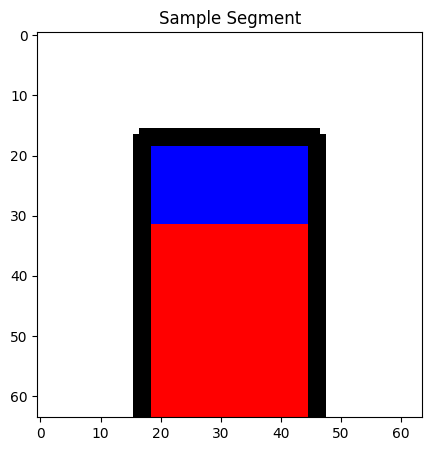

In [1]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

def split_image_into_segments(img_array, segment_size=64):
    """
    Split an image into segments of specified size

    Args:
        img_array (numpy.ndarray): Image as numpy array
        segment_size (int): Size of each segment (square)

    Returns:
        list: List of image segments as numpy arrays
    """
    height, width = img_array.shape[:2]
    segments = []

    # Calculate how many complete segments we can get
    rows = height // segment_size
    cols = width // segment_size

    for i in range(rows):
        for j in range(cols):
            # Extract segment using array slicing
            y_start = i * segment_size
            y_end = (i + 1) * segment_size
            x_start = j * segment_size
            x_end = (j + 1) * segment_size

            segment = img_array[y_start:y_end, x_start:x_end]
            segments.append(segment)

    return segments


# Load image file
img = Image.open("data/collision-tileset.png")
img_array = np.array(img)
segments = split_image_into_segments(img_array)

plt.figure(figsize=(5,5))
plt.imshow(segments[2])
plt.title("Sample Segment")
plt.show()



## 3. Analyze each segment to convert colored areas to polygons (quads)

In [2]:
def extract_rectangles(segment):
    """
    Convert a segment image into rectangles by analyzing runs of similar colors.

    Args:
        segment: numpy array representing an image segment

    Returns:
        list: List of rectangle dictionaries with keys start_x, start_y, end_x, end_y, value
    """
    # Define color mapping
    color_map = lambda r,g,b: {
        (0, 0, 0): 1,
        (255, 255, 255): 1,
        (255, 0, 0): 2,
        (0, 0, 255): 3
    }.get((r, g, b), -1)

    last_pixel_value = None
    runs = []

    # For each row, find runs of pixels with the same value
    for y in range(segment.shape[0]):
        current_run = [{"start_x":0, "start_y": y, "end_x":0, "value":None}]
        for x in range(segment.shape[1]):
            r,g,b,_ = segment[y, x]
            pixel_value = color_map(r, g, b)
            if pixel_value == last_pixel_value or last_pixel_value is None:
                current_run[-1]["end_x"] = x
                current_run[-1]["value"] = pixel_value
            else:
                current_run.append({"start_x": x, "start_y": y, "end_x": x, "value":pixel_value})
            last_pixel_value = pixel_value
        runs.append(current_run)
        last_pixel_value = None  # Reset for next row

    active_rectangles = []
    finished_rectangles = []

    for y, row in enumerate(runs):
        for run in row:
            new = True
            for active_rectangle in active_rectangles:  # Check if run can be added to an active rectangle
                if active_rectangle["value"] == run["value"] and active_rectangle["end_x"] == run["end_x"] and active_rectangle["start_x"] == run["start_x"] and active_rectangle["end_y"] == y - 1:
                    active_rectangle["end_y"] = y
                    new = False
                    break
            if new:  # Start a new rectangle
                active_rectangles.append({
                    "start_x": run["start_x"],
                    "start_y": run["start_y"],
                    "end_x": run["end_x"],
                    "end_y": y,
                    "value": run["value"]
                })

        # Check if any active rectangles are finished
        for active_rectangle in active_rectangles:
            if active_rectangle["end_y"] == y-1:
                finished_rectangles.append(active_rectangle)
        # Remove finished rectangles from active list
        active_rectangles = [active_rectangle for active_rectangle in active_rectangles if active_rectangle["end_y"] > y-1]

    # Add any remaining active rectangles at the end
    for active_rectangle in active_rectangles:
        finished_rectangles.append(active_rectangle)

    return finished_rectangles

# 4. Output sample segment image with polygons overlayed

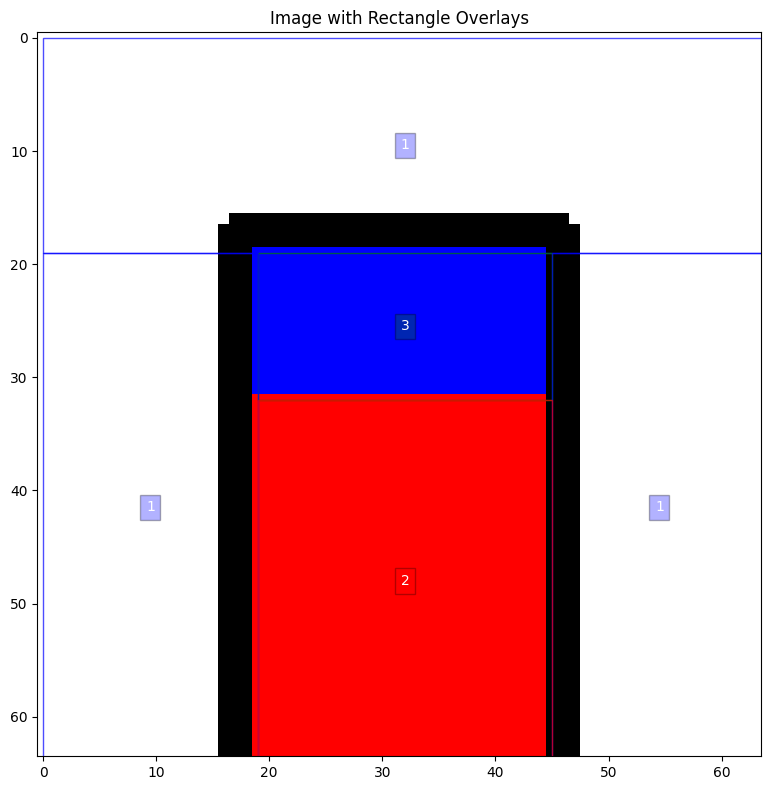

In [3]:
# Plot rectangles over the sample segment

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_rectangles(image, rectangles, figsize=(8, 8)):
        """
        Plot rectangles over an image with colors based on their value.

        Args:
            image: The background image
            rectangles: List of rectangle dictionaries with keys start_x, start_y, end_x, end_y, value
            figsize: Tuple of (width, height) for the figure size in inches
        """
        fig, ax = plt.subplots(figsize=figsize)

        # Display the image
        ax.imshow(image)

        # Color map for different values
        color_map = {
            1: 'blue',
            2: 'red',
            3: 'green',
            -1: 'yellow'
        }

        # Add each rectangle with transparency
        for rect in rectangles:
            # Rectangle coordinates (x, y, width, height)
            x = rect['start_x']
            y = rect['start_y']
            width = rect['end_x'] - rect['start_x'] + 1  # +1 because end_x is inclusive
            height = rect['end_y'] - rect['start_y'] + 1  # +1 because end_y is inclusive

            # Get color based on value with default
            color = color_map.get(rect['value'], 'purple')

            # Add rectangle with transparency
            rectangle = patches.Rectangle(
                (x, y), width, height,
                linewidth=1,
                edgecolor=color,
                facecolor='none',
                alpha=0.7
            )
            ax.add_patch(rectangle)

            # Add text with value in the middle of the rectangle
            ax.text(
                x + width/2,
                y + height/2,
                str(rect['value']),
                color='white',
                fontsize=10,
                ha='center',
                va='center',
                bbox=dict(facecolor=color, alpha=0.3)
            )

        plt.title("Image with Rectangle Overlays")
        plt.tight_layout()
        plt.show()

# Plot rectangles over the sample segment
segment = segments[2]
finished_rectangles = extract_rectangles(segment)
plot_rectangles(segment, finished_rectangles)





# Extra: Plot rectangles over all segments


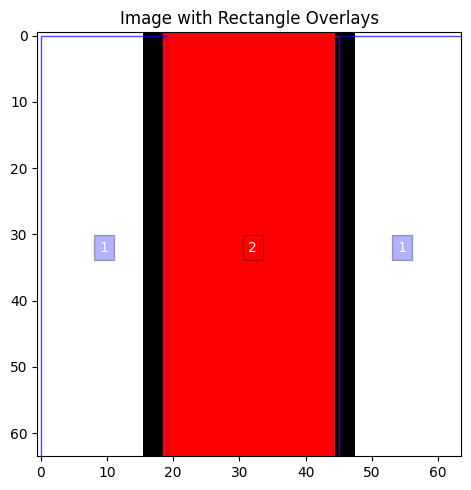

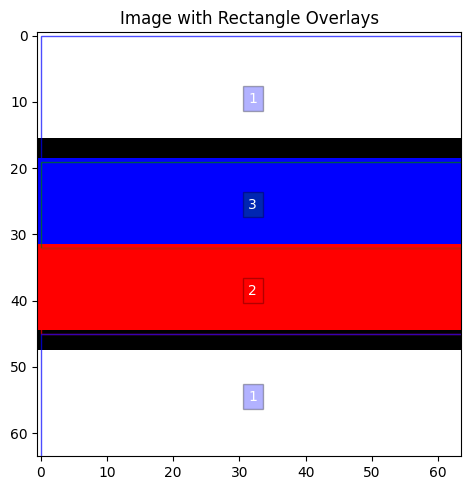

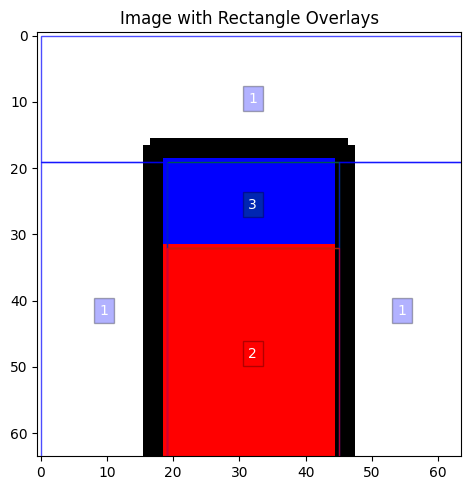

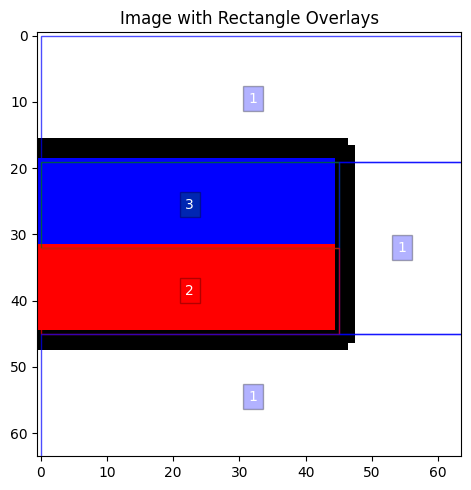

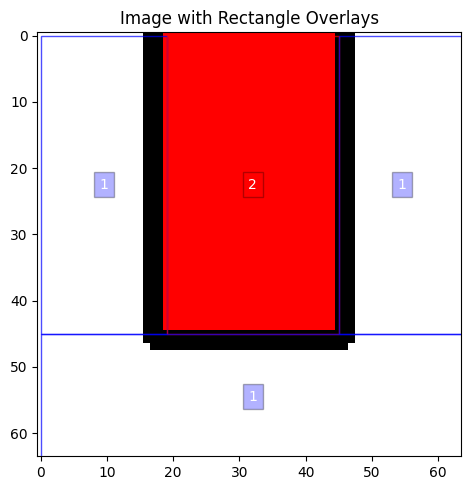

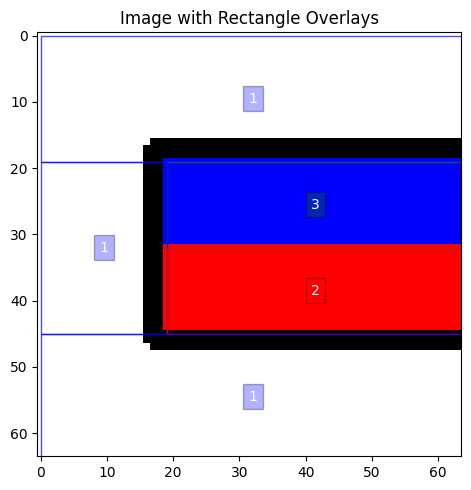

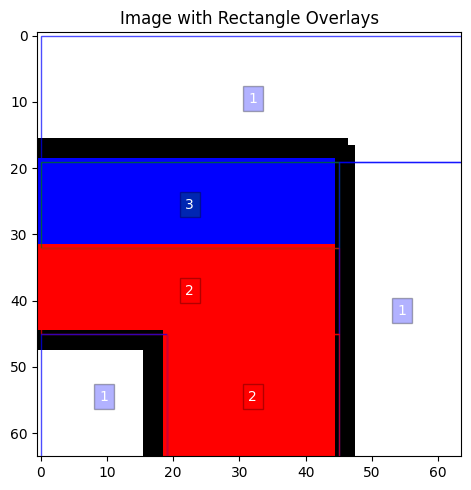

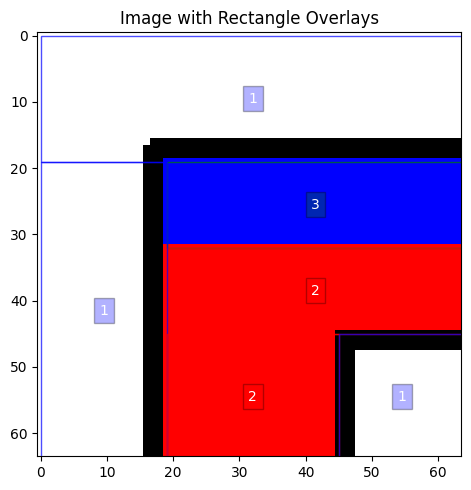

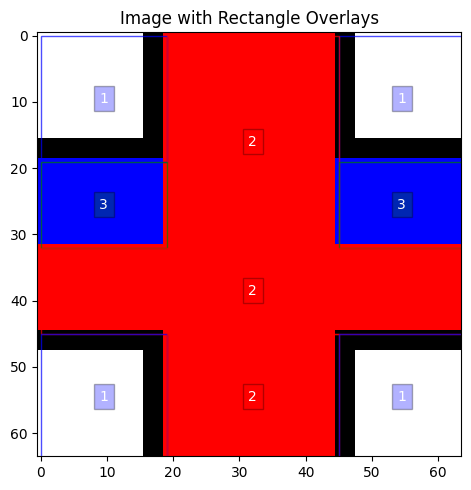

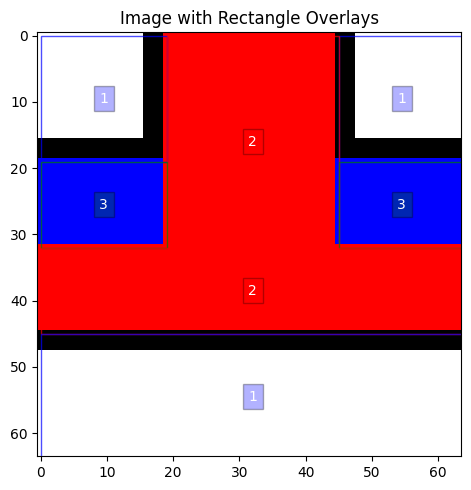

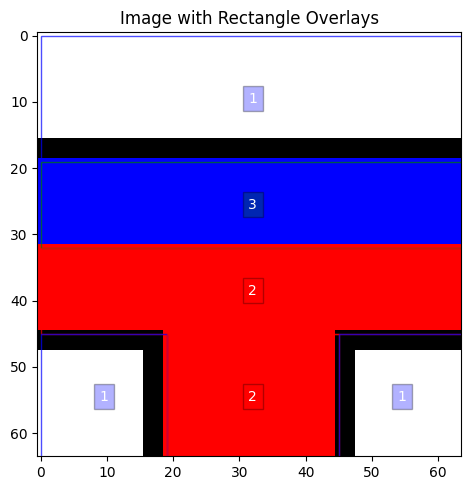

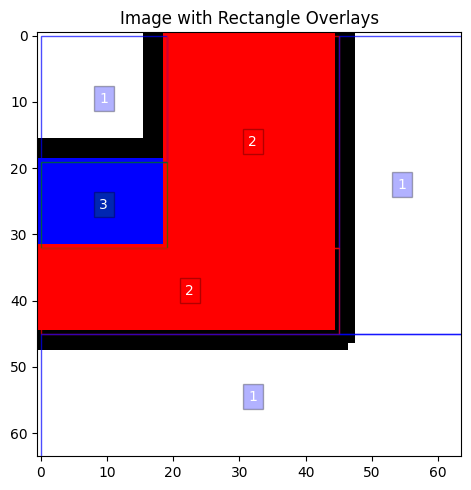

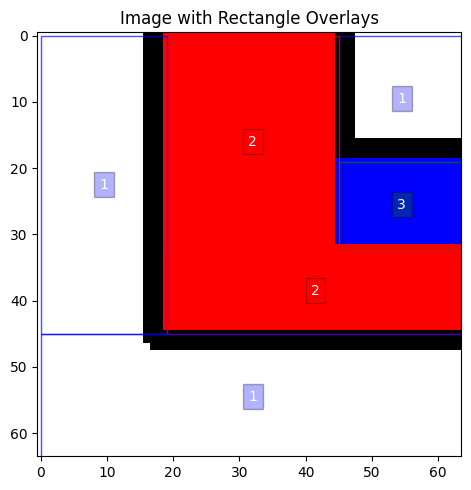

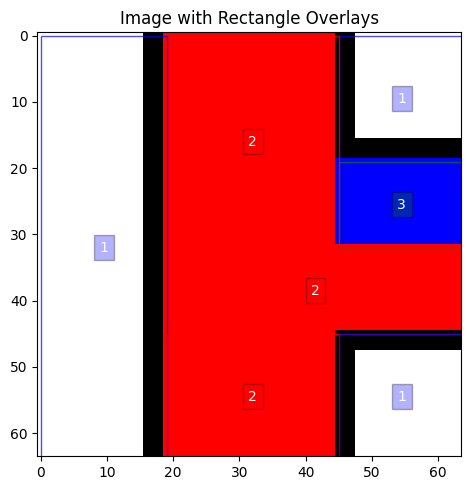

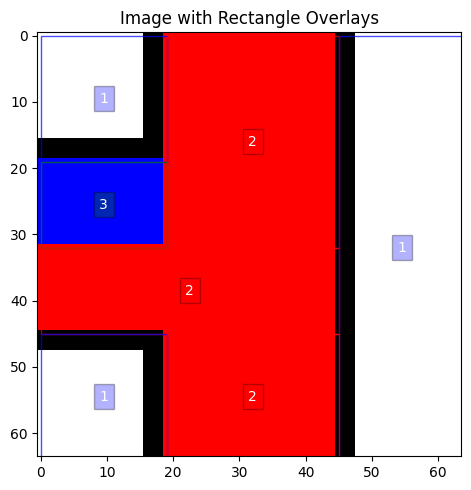

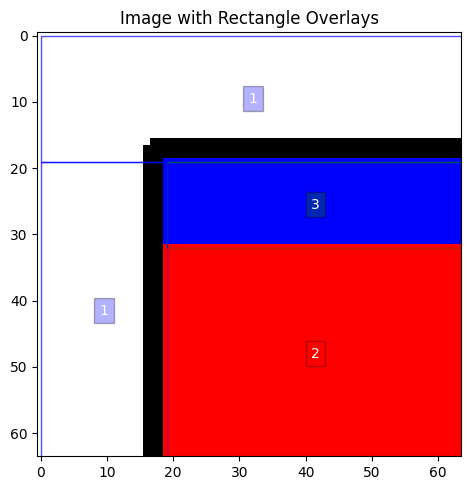

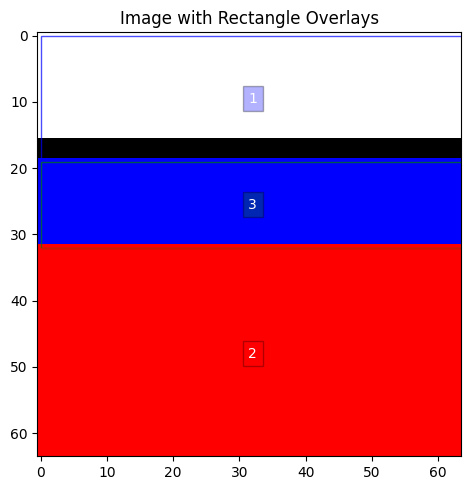

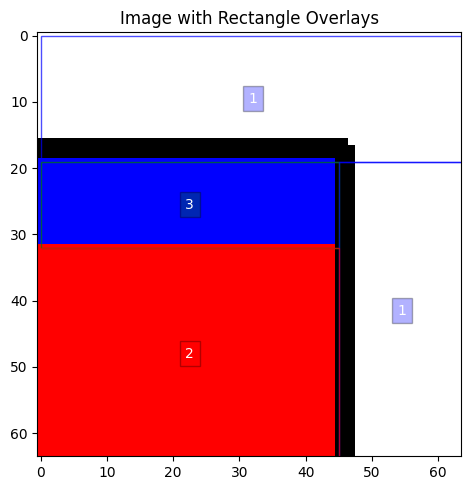

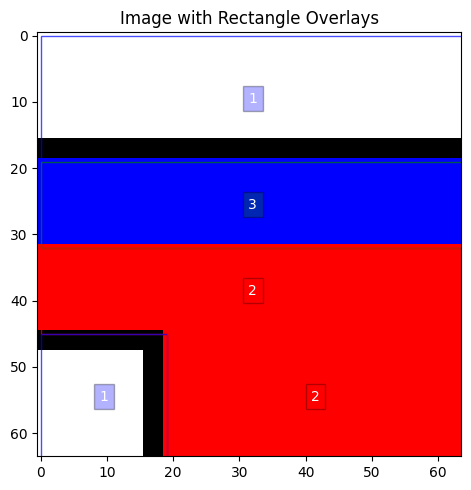

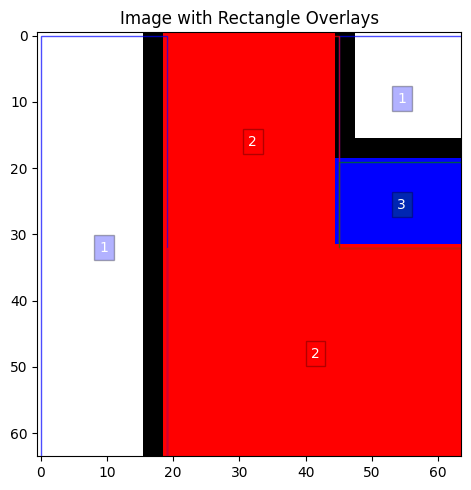

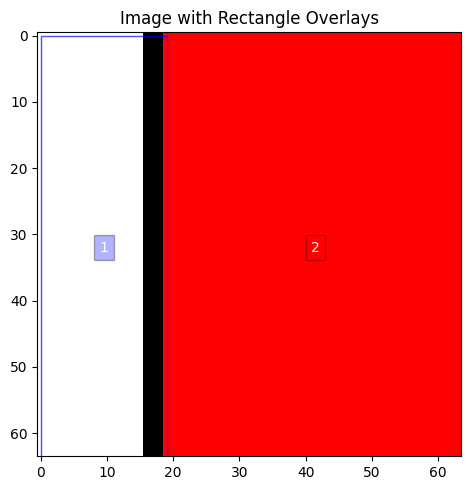

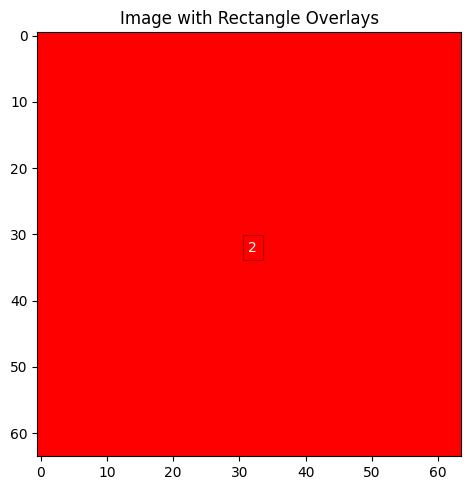

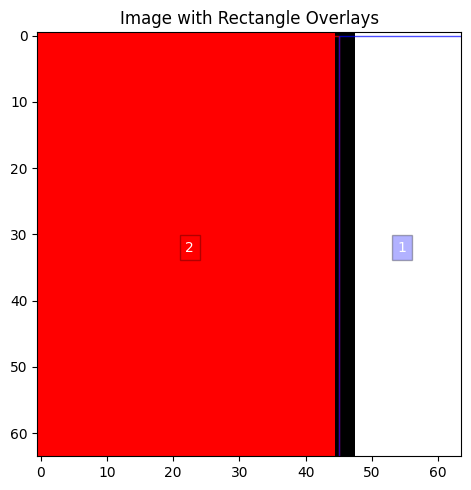

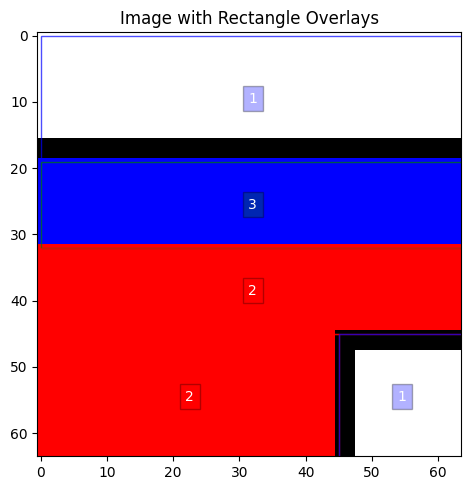

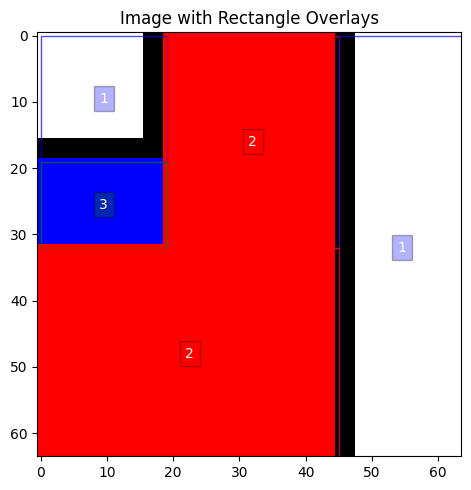

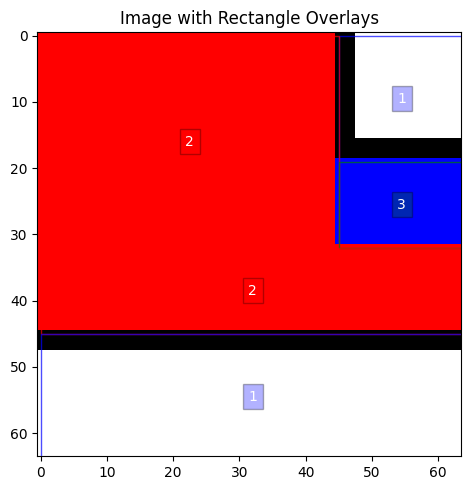

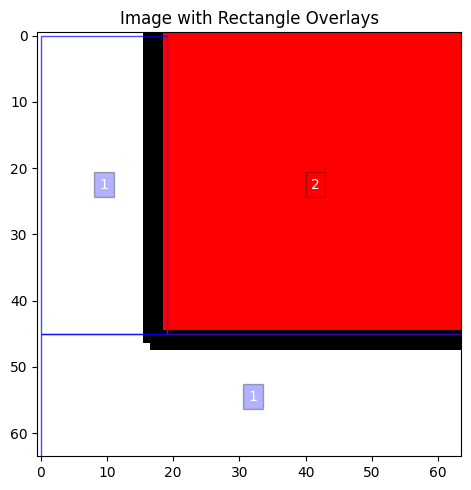

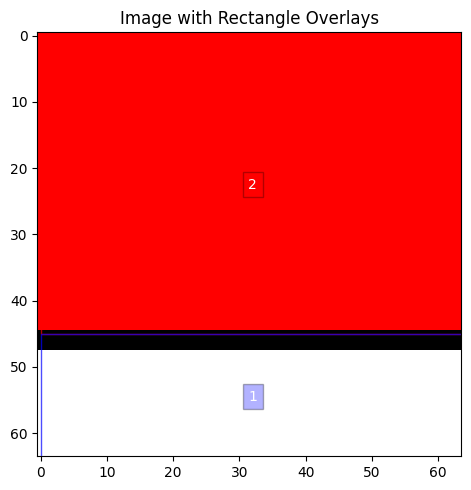

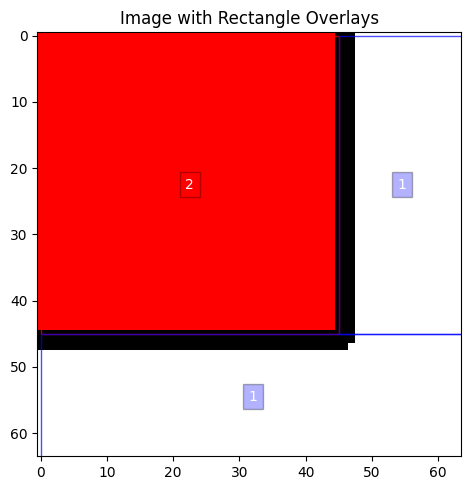

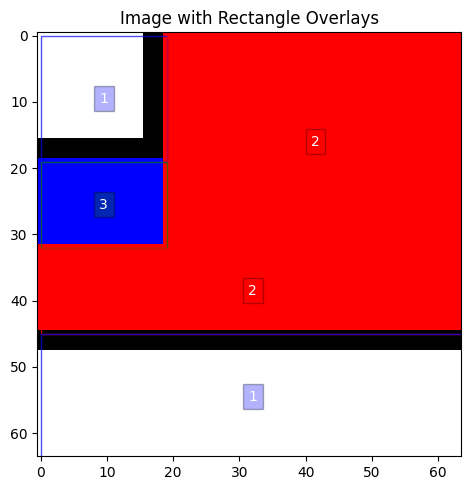

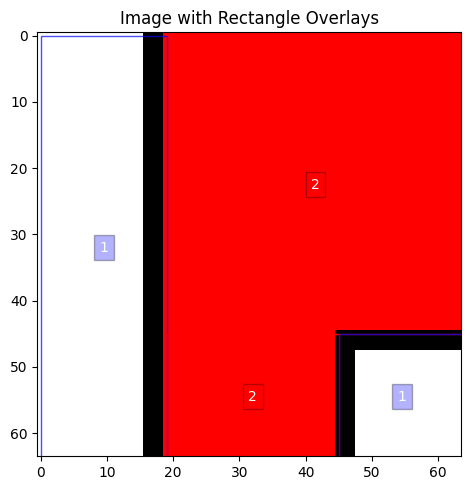

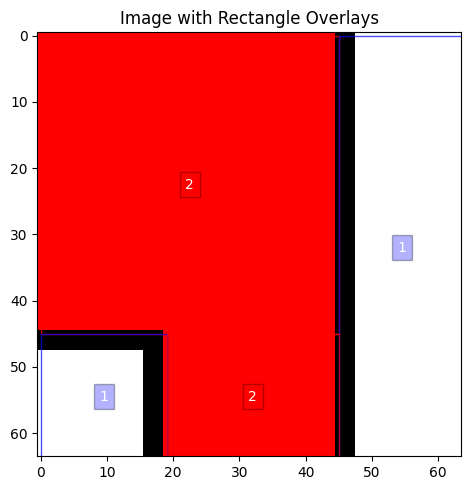

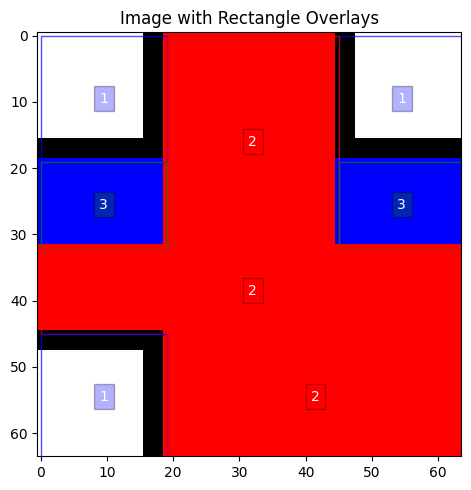

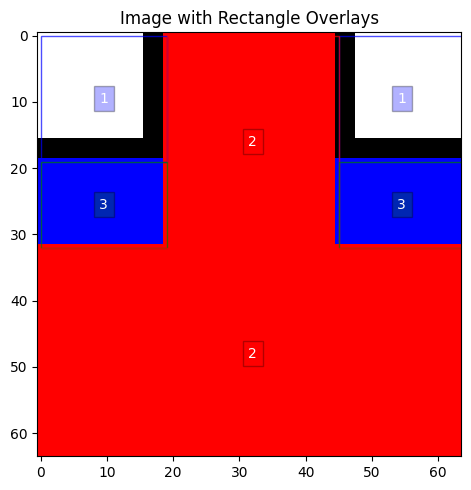

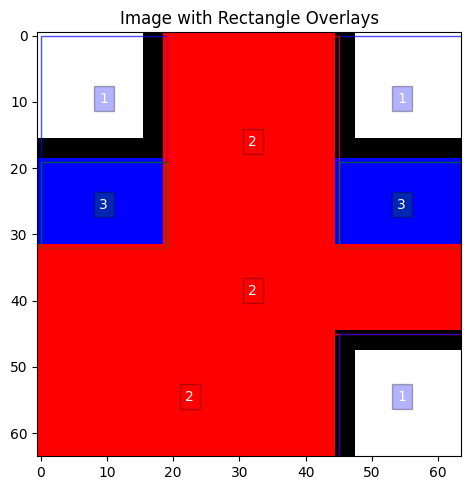

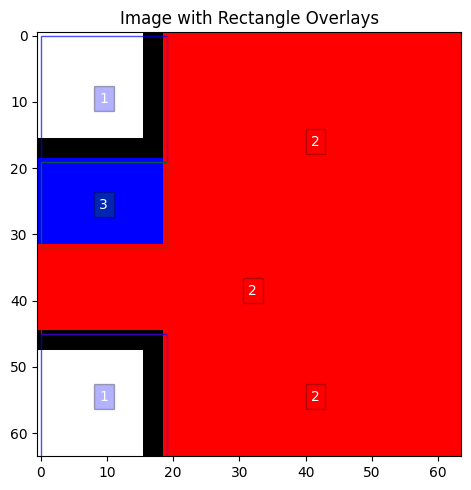

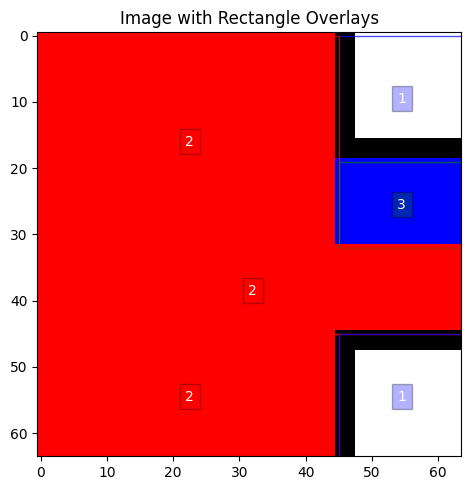

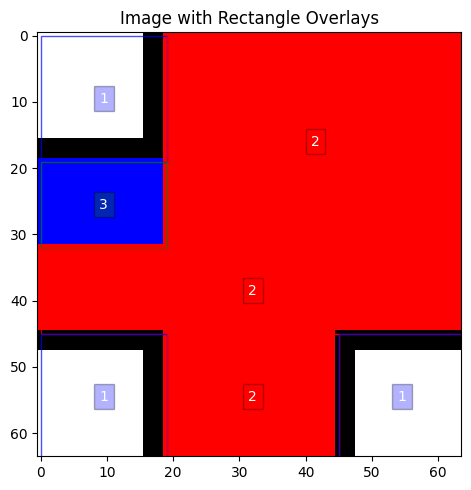

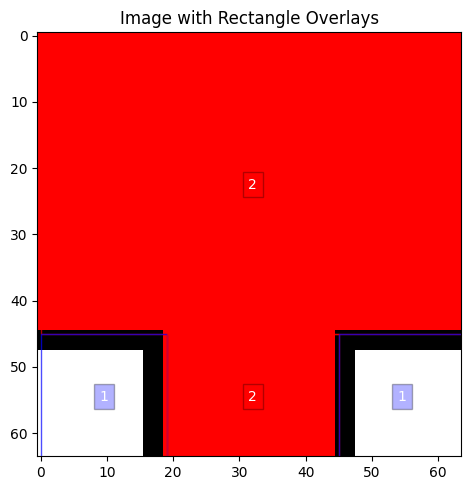

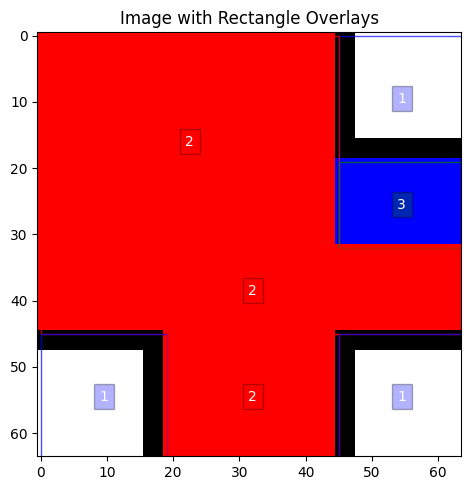

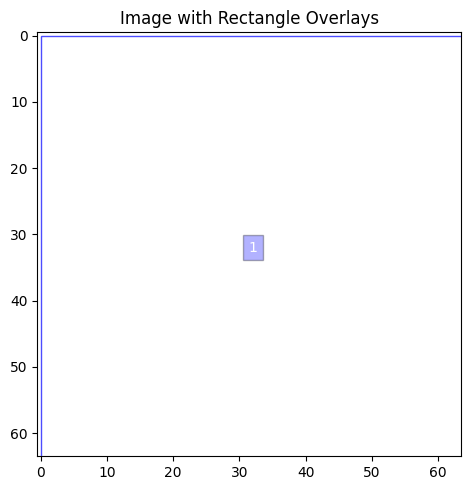

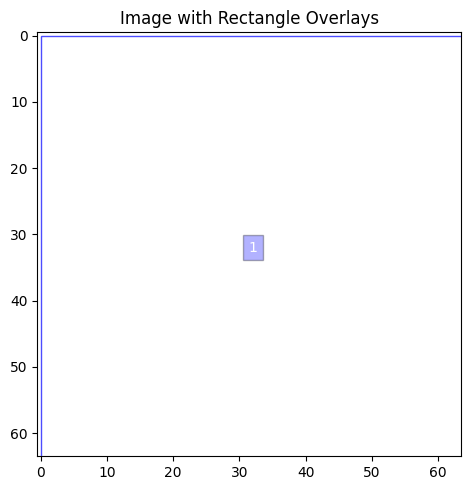

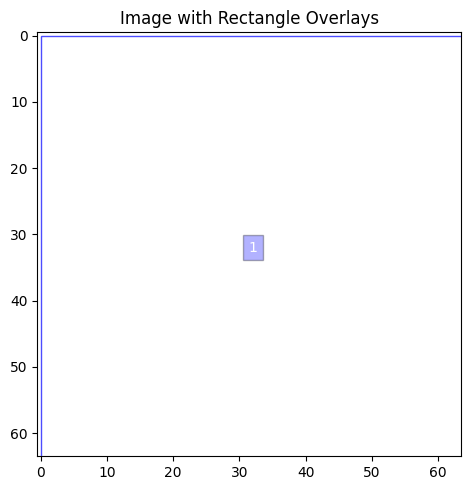

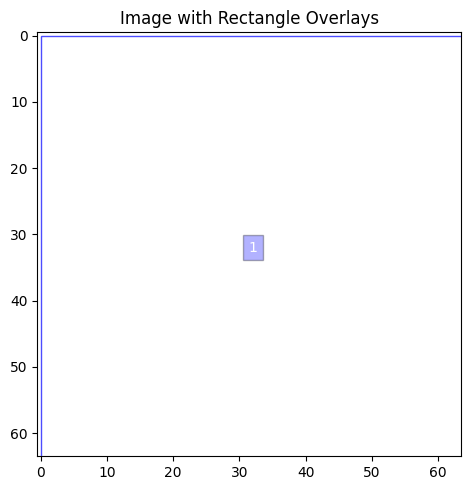

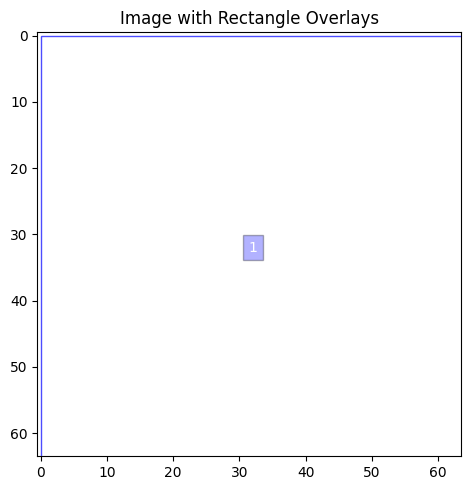

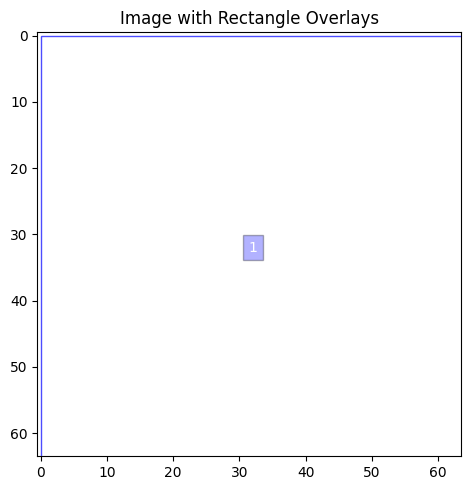

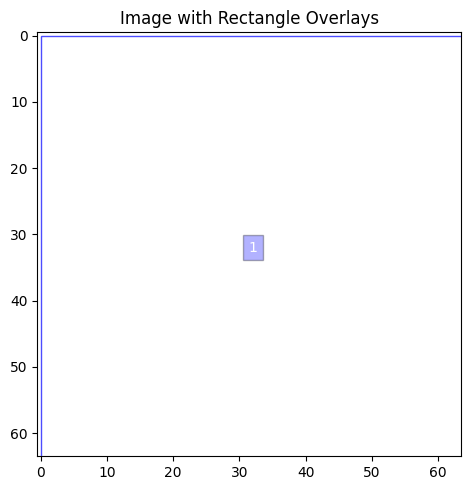

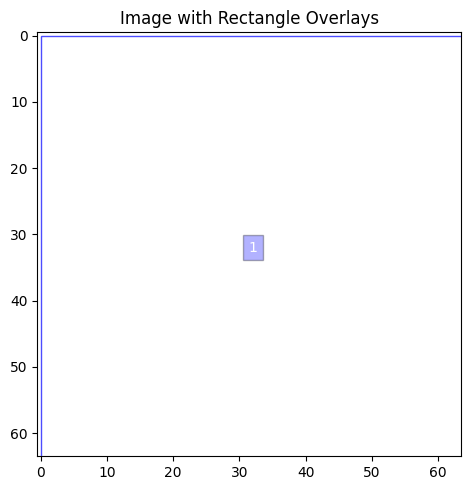

In [4]:
# Plot rectangles over all segments
for i, segment in enumerate(segments):
    finished_rectangles = extract_rectangles(segment)
    plot_rectangles(segment, finished_rectangles, figsize=(5,5))
